In [1]:
import os
import pickle as pkl
from os.path import join as oj

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,plot_roc_curve
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

import imodels
from rulevetting.api import validation, util as api_util
from rulevetting.projects.csi_pecarn.dataset import Dataset
from rulevetting import DATA_PATH
np.random.seed(0)


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Read data
To be able to connect the data from different datasets, we keep CaseID, ControlType and SubjectID.

To do this, you need to mannuly change "feats = df.keys()[4:]" in datatset.py::extract_features to "feats = df.keys()[1:]"

In [3]:
df_train, df_tune, df_test = Dataset().get_data(save_csvs=True,load_csvs=False)
outcome_def = 'outcome'  # output
meta_keys = api_util.get_feat_names_from_base_feats(df_train.columns, Dataset().get_meta_keys())

X_train = df_train.drop(columns=meta_keys)
# .drop(columns='CaseID').drop(columns='ControlType')
X_tune = df_tune.drop(columns=meta_keys)
# .drop(columns='CaseID').drop(columns='ControlType')
X_test = df_test.drop(columns=meta_keys)
# .drop(columns='CaseID').drop(columns='ControlType')

y_train = X_train[outcome_def].values
X_train = X_train.drop(columns=[outcome_def])
y_tune = X_tune[outcome_def].values
X_tune = X_tune.drop(columns=[outcome_def])
y_test = X_test[outcome_def].values
X_test = X_test.drop(columns=[outcome_def])

X_train_all=pd.concat((X_train, X_tune))
y_train_all=np.concatenate((y_train, y_tune))

X_all=pd.concat((X_train, X_tune, X_test))
y_all=np.concatenate((y_train, y_tune, y_test))

processed_feats = X_train.keys().values.tolist()
feature_names = processed_feats
# X_train_all.head

kwargs {'clean_data': {'include_intervention': False}, 'preprocess_data': {'unclear_feat_default': 0, 'only_site_data': 2, 'augmented_features': False, 'use_control_type': 'all'}, 'extract_features': {'drop_negative_columns': False}}


# Create the best model 
The best model is RuleFitClassifier with hyperparameters max_rules=13, n_estimators=50,  include_linear=True, cv=False,random_state=0
Prerequirement: imodel package needs to be updated.

In [32]:
rulefit = imodels.RuleFitClassifier(max_rules=13, n_estimators=50,  include_linear=True, cv=False,random_state=0)
rulefit.fit(X_train_all, y_train_all, feature_names=feature_names)

RuleFitClassifier(cv=False, max_rules=13, n_estimators=50, random_state=0)

In [33]:
pkl.dump(rulefit, open('rulefit_model.sav', 'wb'))


# Rules

In [47]:
rulefit.visualize()

,rule,coef
14,PainNeck2,0.06
29,axialloadtop <= 0.5 and Torticollis2 <= 0.5 and HighriskDiving <= 0.5,-0.14
28,Torticollis2 <= 0.5 and subinj_TorsoTrunk2 <= 0.5 and HighriskDiving <= 0.5,-0.27
26,FocalNeuroFindings2 <= 0.5 and Predisposed <= 0.5,-0.12
24,FocalNeuroFindings2 <= 0.5 and Torticollis2 <= 0.5 and subinj_TorsoTrunk2 <= 0.5 and HighriskDiving <= 0.5,-0.32
27,FocalNeuroFindings2 <= 0.5 and HighriskDiving <= 0.5 and HighriskMVC <= 0.5,-0.71
25,AlteredMentalStatus2 <= 0.5 and FocalNeuroFindings2 <= 0.5 and Torticollis2 <= 0.5 and HighriskDiving <= 0.5,-0.61
23,FocalNeuroFindings2 <= 0.5 and PainNeck2 <= 0.5 and subinj_TorsoTrunk2 <= 0.5,-0.33
22,axialloadtop <= 0.5 and AlteredMentalStatus2 <= 0.5 and FocalNeuroFindings2 <= 0.5 and PainNeck2 <= 0.5 and Torticollis2 <= 0.5,-0.86


# PR curve and choose the threshold

# When sensitivity = 96.6  and specificity=36.4

/Users/yuhaod/Desktop/csi/rule-env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


choose threshold: 0.001792346617936121
sensitivity: 0.9661016949152542
specificity: 0.3642172523961661


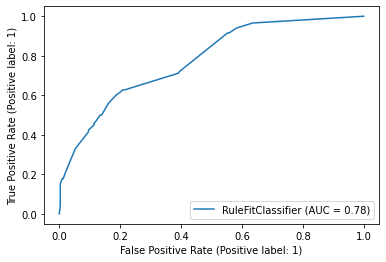

In [59]:
X_test= check_array(X_test)
prediction_prob=rulefit.predict_proba(X_test)
fpr, tpr, threshold_lists=roc_curve(y_test, prediction_prob[:,1])
sensitivity=tpr
specificity=1-fpr
plot_roc_curve(rulefit, X_test, y_test) 
thres=-3    # index for threshold

print(f'choose threshold: {threshold_lists[thres]}')
print(f'sensitivity: {sensitivity[thres]}')
print(f'specificity: {specificity[thres]}')

## Prediction and find the indices of false negative 

In [54]:
prediction=prediction_prob[:,1] >= threshold_lists[thres]
# print(f'number of predicted positive: {sum(prediction)}')
# print(f'number of true positive: {sum(y_all)}')
false_negative_idx=[]
for idx, (first,second) in enumerate(zip(prediction,y_test)):
    if first==0 and second==1:
        false_negative_idx.append(idx)
print(f'number of false negative: {len(false_negative_idx)}')

number of false negative: 4


## Check the meta-keys for the false negative cases

In [60]:
X_train_meta = df_train[meta_keys]
X_tune_meta = df_tune[meta_keys]
X_test_meta = df_test[meta_keys]
# X_all_meta=pd.concat((X_train_meta, X_tune_meta, X_test_meta)).reset_index().drop(columns='SITE').drop(columns='index')

X_all_meta=df_test[meta_keys].reset_index().drop(columns='SITE').drop(columns='index')

# .drop(columns='StudySubjectID')
cols = X_all_meta.columns.tolist()
cols = cols[-1:] + cols[:-1]
X_all_meta = X_all_meta[cols]
# 
X_all_meta=X_all_meta.loc[:, X_all_meta.any()].dropna(axis=1,how='all')
X_false_negative_meta=X_all_meta.iloc[false_negative_idx].loc[:, X_all_meta.any()]
X_false_negative_meta.reset_index(drop=True, inplace=True)
X_false_negative_meta['CaseID']=X_false_negative_meta['CaseID'].apply(np.int64)
X_false_negative_meta.sort_values(by=['StudySubjectID'])


/Users/yuhaod/Desktop/csi/rule-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,StudySubjectID,CaseID,ControlType,EDDisposition,IntervForCervicalStab,IntervForCervicalStabBrace,IntervForCervicalStabHalo,IntervForCervicalStabIntFix,IntervForCervicalStabIntFixtxt,IntervForCervicalStabOther,IntervForCervicalStabOthertxt,IntervForCervicalStabRCollar,IntervForCervicalStabSCollar,IntervForCervicalStabSurgical,IntervForCervicalStabTraction,LongTermRehab,OutcomeStudySiteBowel,OutcomeStudySiteMobility,OutcomeStudySiteMobility1,OutcomeStudySiteMobility2,OutcomeStudySiteNeuro,OutcomeStudySiteUrine
2,420501.0,410466,ems,HOME,N,0,0,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0
3,710857.0,710857,case,GEN,Y,0,1,1,C1-C2 posterior fusion,0,0,1,0,1,0,Y,0,0,0,0,0,0
1,1041815.0,1011642,ran,GEN,N,0,0,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0
0,1111837.0,1111837,case,ICU,Y,0,0,0,0,0,0,1,0,0,0,Y,N,DA,0,0,MD,N


# Check injuryclassification.csv


In [56]:
CaseID=[]
for i in df_train.iloc[false_negative_idx]['CaseID'].tolist():
    CaseID.append(int(i))
df_injury=pd.read_csv('/Users/yuhaod/Desktop/csi/rule-vetting/data/csi_pecarn/raw/injuryclassification.csv')
df_injury=df_injury.loc[ df_injury['CaseID'].isin(CaseID)].drop(columns='SITE').drop(columns='StudySubjectID')
# .drop(columns='CaseID').drop(columns='ControlType').drop(columns='StudySubjectID').drop(columns='SITE')
df_injury=df_injury.loc[:, df_injury.any()].dropna(axis=1,how='all')
df_injury.reset_index(drop=True, inplace=True)
df_injury.sort_values(by=['CaseID'])
# X_tune_meta = df_tune[meta_keys]
# X_test_meta = df_test[meta_keys]
# X_all_meta=pd.concat((X_train_meta, X_tune_meta, X_test_meta)).reset_index()

,CaseID,ControlType,CSFractures,CFracturesC2,C2SbFractureBOOT,C2SbFractureBOOTypeOR,C2SbFractureBOOTypeORtxt,Ligamentoptions,LigamentousInjuryOAD,LigamentousInjuryC23,C2_3SbLigSL,C2_3SbLigAL,LigamentousInjuryC56,C5_6SbLigSC,C5_6SbLigSCWSC,LigamentousInjuryC7T1,C7_T1SbLigSC,C7_T1SbLigSCPL,CSpineSignalChange,SignalChangeLevelC5,SignalChangeLevelC6,SignalChangeLevelC7,CordInjuryNoRadiographic
0,410466,case,N,0,0,0,NaN,Y,0,1,1,1,0,0,0,0,0,0,N,0,0,0,N
1,710857,case,Y,1,1,1,synchondroses,N,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,N
2,1011642,case,N,0,0,0,NaN,Y,1,0,0,0,0,0,0,0,0,0,NaN,0,0,0,N
3,1111837,case,N,0,0,0,NaN,Y,0,0,0,0,1,1,1,1,1,1,Y,1,1,1,N


# When sensitivity = 91.5  and specificity=44.7

/Users/yuhaod/Desktop/csi/rule-env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


choose threshold: 0.0051819699015513134
sensitivity: 0.9152542372881356
specificity: 0.44728434504792336


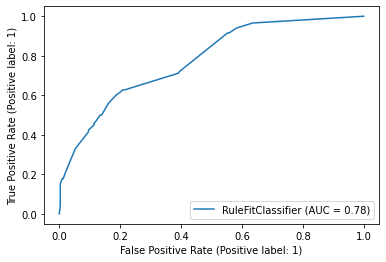

In [43]:
X_test= check_array(X_test)
prediction_prob=rulefit.predict_proba(X_test)
fpr, tpr, threshold_lists=roc_curve(y_test, prediction_prob[:,1])
sensitivity=tpr
specificity=1-fpr
plot_roc_curve(rulefit, X_test, y_test) 
thres=-6 # index for threshold

print(f'choose threshold: {threshold_lists[thres]}')
print(f'sensitivity: {sensitivity[thres]}')
print(f'specificity: {specificity[thres]}')

## Prediction and find the indices of false negative 

In [44]:
prediction=prediction_prob[:,1] >= threshold_lists[thres]
# print(f'number of predicted positive: {sum(prediction)}')
# print(f'number of true positive: {sum(y_all)}')
false_negative_idx=[]
for idx, (first,second) in enumerate(zip(prediction,y_test)):
    if first==0 and second==1:
        false_negative_idx.append(idx)
print(f'number of false negative: {len(false_negative_idx)}')

number of false negative: 10


## Check the meta-keys for the false negative cases

In [45]:
X_train_meta = df_train[meta_keys+['CaseID']]
X_tune_meta = df_tune[meta_keys+['CaseID']]
X_test_meta = df_test[meta_keys+['CaseID']]
X_all_meta=pd.concat((X_train_meta, X_tune_meta, X_test_meta)).reset_index().drop(columns='SITE').drop(columns='index').drop(columns='StudySubjectID')
cols = X_all_meta.columns.tolist()
cols = cols[-1:] + cols[:-1]
X_all_meta = X_all_meta[cols]
# 
X_all_meta=X_all_meta.loc[:, X_all_meta.any()].dropna(axis=1,how='all')
X_false_negative_meta=X_all_meta.iloc[false_negative_idx].loc[:, X_all_meta.any()]
X_false_negative_meta.reset_index(drop=True, inplace=True)
X_false_negative_meta['CaseID']=X_false_negative_meta['CaseID'].apply(np.int64)
X_false_negative_meta.sort_values(by=['CaseID'])

ValueError: The column label 'CaseID' is not unique.

# Check injury classification


In [49]:
CaseID=[]
for i in df_train.iloc[false_negative_idx]['CaseID'].tolist():
    CaseID.append(int(i))
df_injury=pd.read_csv('/Users/yuhaod/Desktop/csi/rule-vetting/data/csi_pecarn/raw/injuryclassification.csv')
df_injury=df_injury.loc[ df_injury['CaseID'].isin(CaseID)].drop(columns='SITE').drop(columns='StudySubjectID')
# .drop(columns='CaseID').drop(columns='ControlType').drop(columns='StudySubjectID').drop(columns='SITE')
df_injury=df_injury.loc[:, df_injury.any()].dropna(axis=1,how='all')
df_injury.reset_index(drop=True, inplace=True)
df_injury.sort_values(by=['CaseID'])
# X_tune_meta = df_tune[meta_keys]
# X_test_meta = df_test[meta_keys]
# X_all_meta=pd.concat((X_train_meta, X_tune_meta, X_test_meta)).reset_index()

,CaseID,ControlType,CSFractures,CFracturesC2,C2SbFractureBOOT,C2SbFractureBOOTypeOR,C2SbFractureBOOTypeORtxt,CFracturesC4,C4SbFractureBY,C4SbFractureBYOR,C4SbFractureBYORtxt,CFracturesC5,C5SbFractureBY,C5SbFractureBYB,C5SbFractureBYTD,C5SbFractureBYLH,C5SbFractureLA,C5SbFractureCC,CFracturesC7,C7SbFractureBY,C7SbFractureBYWC,C7SbFractureSP,Ligamentoptions,LigamentousInjuryOAD,LigamentousInjuryC12,C1_2SbLigSL,C1_2SbLigSLARS,LigamentousInjuryC23,C2_3SbLigSL,C2_3SbLigAL,C2_3SbLigSC,C2_3SbLigSCAL,LigamentousInjuryC45,C4_5SbLigSC,C4_5SbLigSCAL,LigamentousInjuryC56,C5_6SbLigAL,C5_6SbLigSC,C5_6SbLigSCAL,C5_6SbLigSCWSC,C5_6SbLigSCPL,LigamentousInjuryC7T1,C7_T1SbLigSC,C7_T1SbLigSCPL,CSpineSignalChange,SignalChangeLevelC2,SignalChangeLevelC3,SignalChangeLevelC4,SignalChangeLevelC5,SignalChangeLevelC6,SignalChangeLevelC7,CordInjuryNoRadiographic
0,410466,case,N,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,Y,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0,N
1,710857,case,Y,1,1,1,synchondroses,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,N
2,710870,case,Y,0,0,0,NaN,0,0,0,NaN,1,1,0,1,0,0,1,0,0,0,0,Y,0,0,0,0,1,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,Y,1,1,1,1,1,0,N
3,1011642,case,N,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,Y,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,N
4,1111837,case,N,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,1,Y,0,0,0,1,1,1,N
5,1111839,case,Y,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,0,1,0,0,1,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,N
6,1111870,case,N,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0,Y
7,1312191,case,N,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,Y,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,N
8,1412379,case,Y,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,0,1,1,1,0,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,N
9,1512495,case,Y,0,0,0,NaN,1,1,1,Sagittal split,1,1,1,0,1,1,1,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,Y,0,0,1,1,1,0,N
